# ==============================
# 1. IMPORTS & ENV
# ==============================

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
from sqlalchemy import create_engine
import os

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# ==============================
# 2. LOAD DATA
# ==============================

In [4]:
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS') 
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
# Create SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

try:
    # Read tables into DataFrames
    card = pd.read_sql_table('cards_data', con=engine)
    trans = pd.read_sql_table('transactions_data', con=engine)
    users = pd.read_sql_table('users_data', con=engine)
    
    # For fraud labels
    df1 = pd.read_sql_query("SELECT id, status AS Status FROM train_fraud_labels", con=engine)
    
    # For MCC codes  
    df2 = pd.read_sql_query("SELECT mcc, name AS Name FROM mcc_codes", con=engine)
    
except Exception as e:
    print(f"Database error: {e}")
finally:
    # Close connection
    engine.dispose()

# ==============================
# 3. HELPER FUNCTION
# ==============================

In [6]:
def checkDataset(dataset):
    nuuniq = []
    dtyp = []
    uuniq = []
    for col in dataset.columns:
        nuuniq.append(dataset[col].nunique())
        dtyp.append(dataset[col].dtype)
        sample = dataset[col].dropna()
        uuniq.append(sample.iloc[0] if len(sample) > 0 else None)
    result = pd.DataFrame({
        "Column Name": dataset.columns,
        'Count of Unique values': nuuniq,
        'Assigned Datatype': dtyp,
        'Sample Value': uuniq
    })
    return result

# ==============================
# 4. PROCESS DATA
# ==============================


* ### 4.1 PROCESS CARDS DATA

In [7]:
print("\n=== PROCESSING CARDS DATA ===")
print("Duplicates:", card.duplicated().sum())
print("Nulls:\n", card.isnull().sum())



=== PROCESSING CARDS DATA ===
Duplicates: 0
Nulls:
 id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64


In [8]:
result = checkDataset(card)
result

,Column Name,Count of Unique values,Assigned Datatype,Sample Value
0,id,6146,int64,4524
1,client_id,2000,int64,825
2,card_brand,4,object,Visa
3,card_type,3,object,Debit
4,card_number,6146,int64,4344676511950444
5,expires,259,object,12/2022
6,cvv,998,int64,623
7,has_chip,2,object,YES
8,num_cards_issued,3,int64,2
9,credit_limit,3654,object,$24295


**Considerations**

* The column 'card_on_dark_web' has a constant value.

**Issues Found:**
* The column 'Expires' and 'acct_open_date' is misassiged as object and should be datetime.
* 'credit_limit' column is misassigned as object It should be numeric.

In [9]:
# Fix datatypes
card['expires'] = pd.to_datetime(card['expires'])
card['acct_open_date'] = pd.to_datetime(card['acct_open_date'])

card['credit_limit'] = card['credit_limit'].str.replace('$', '', regex=False)
card['credit_limit'] = pd.to_numeric(card['credit_limit'])

card.rename(columns={'credit_limit': 'Credit_Limit($)'}, inplace=True)

print("\nAfter cleaning:")
display(checkDataset(card))




After cleaning:


,Column Name,Count of Unique values,Assigned Datatype,Sample Value
0,id,6146,int64,4524
1,client_id,2000,int64,825
2,card_brand,4,object,Visa
3,card_type,3,object,Debit
4,card_number,6146,int64,4344676511950444
5,expires,259,datetime64[ns],2022-12-01 00:00:00
6,cvv,998,int64,623
7,has_chip,2,object,YES
8,num_cards_issued,3,int64,2
9,Credit_Limit($),3654,int64,24295


* ### 4.2 PROCESS USERS DATA

In [10]:
print("\n=== PROCESSING USERS DATA ===")
print("Duplicates:", users.duplicated().sum())
print("Nulls:\n", users.isnull().sum())


=== PROCESSING USERS DATA ===
Duplicates: 0
Nulls:
 id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64


In [11]:
# Checking if correct datatypes are assigned to the columns
result = checkDataset(users)
result

,Column Name,Count of Unique values,Assigned Datatype,Sample Value
0,id,2000,int64,825
1,current_age,80,int64,53
2,retirement_age,29,int64,66
3,birth_year,80,int64,1966
4,birth_month,12,int64,11
5,gender,2,object,Female
6,address,1999,object,462 Rose Lane
7,latitude,989,float64,34.15
8,longitude,1224,float64,-117.76
9,per_capita_income,1754,object,$29278


* The columns 'per_capita_income', 'yearly_income' and 'total_debt' columns are assigned as object. Resolving the issue and changing the datatype to numeric.

In [12]:
# Clean currency columns
for col in ['per_capita_income', 'yearly_income', 'total_debt']:
    users[col] = users[col].str.replace('$', '', regex=False)
    users[col] = pd.to_numeric(users[col])

users.rename(columns={
    "per_capita_income": "per_capita_income($)",
    "yearly_income": "yearly_income($)",
    "total_debt": "total_debt($)"
}, inplace=True)

print("\nAfter cleaning:")
display(checkDataset(users))


After cleaning:


,Column Name,Count of Unique values,Assigned Datatype,Sample Value
0,id,2000,int64,825
1,current_age,80,int64,53
2,retirement_age,29,int64,66
3,birth_year,80,int64,1966
4,birth_month,12,int64,11
5,gender,2,object,Female
6,address,1999,object,462 Rose Lane
7,latitude,989,float64,34.15
8,longitude,1224,float64,-117.76
9,per_capita_income($),1754,int64,29278


* ### 4.2.1 MERGE DATA

In [13]:
# Merge users + cards
dfr = pd.merge(users, card, on='id', how='inner')

* ### 4.3 PROCESS MCC CODES



In [14]:
df2.head()

,mcc,Name
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mcc     109 non-null    object
 1   Name    109 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


* The column 'mcc' is misassigned as 'object' and should be 'int'

In [16]:
print("\n=== PROCESSING MCC CODES ===")
df2['mcc'] = pd.to_numeric(df2['mcc'])
print("Duplicates:", df2.duplicated().sum())
print("Nulls:\n", df2.isnull().sum())


=== PROCESSING MCC CODES ===
Duplicates: 0
Nulls:
 mcc     0
Name    0
dtype: int64


* ### 4.4 PROCESS FRAUD LABELS


In [17]:
df1.head()

,id,Status
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      object
 1   Status  object
dtypes: object(2)
memory usage: 136.0+ MB


In [19]:
print("\n=== PROCESSING FRAUD LABELS ===")
df1['id'] = pd.to_numeric(df1['id'])
print("Duplicates:", df1.duplicated().sum())
print("Nulls:\n", df1.isnull().sum())


=== PROCESSING FRAUD LABELS ===
Duplicates: 0
Nulls:
 id        0
Status    0
dtype: int64


* ### 4.5 PROCESS TRANSACTIONS

In [20]:
trans.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [21]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


# ==============================
# 5. MERGE ALL
# ==============================


In [22]:
# Merge trans + fraud labels
df = pd.merge(trans, df1, on='id', how='inner')

In [23]:
# Merge with MCC names
df = pd.merge(df, df2, on='mcc', how='inner')

In [24]:
df.columns

Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'Status', 'Name'],
      dtype='object')

# ==============================
# 6. DATA CLEAN
# ==============================


In [25]:
result = checkDataset(df)
result

,Column Name,Count of Unique values,Assigned Datatype,Sample Value
0,id,8914963,int64,7475327
1,date,3680988,object,2010-01-01 00:01:00
2,client_id,1219,int64,1556
3,card_id,4070,int64,2972
4,amount,70639,object,$-77.00
5,use_chip,3,object,Swipe Transaction
6,merchant_id,66537,int64,59935
7,merchant_city,12173,object,Beulah
8,merchant_state,199,object,ND
9,zip,24586,float64,58523.0


Observations:
* The 'Amount' column is wrong wrongly assigned as 'Object' due to the presence of '$' in the value.

Issues found:
* Presence of negative values in the amount column
* Presence of NAN values in 'errors' column

In [26]:
# Clean 'amount'
df['amount'] = df['amount'].str.replace('$', '', regex=False)
df['amount'] = pd.to_numeric(df['amount'])
df.rename(columns={'amount': 'Amount($)'}, inplace=True)

In [27]:
miss = []
rows = df.shape[0]
per = []

for col in df.columns:
    missing = df[col].isnull().sum()
    miss.append(missing)
    percent = ( missing / rows)*100
    per.append(percent)

res = pd.DataFrame({'Column Name': df.columns, 'Missing Values': miss, 'Percentage of null values': per})
res

,Column Name,Missing Values,Percentage of null values
0,id,0,0.000000
1,date,0,0.000000
2,client_id,0,0.000000
3,card_id,0,0.000000
4,Amount($),0,0.000000
5,use_chip,0,0.000000
6,merchant_id,0,0.000000
7,merchant_city,0,0.000000
8,merchant_state,1047865,11.754003
9,zip,1107377,12.421555


* since major transactions are generally error-free

In [28]:
df['errors'].fillna('No Error', inplace=True)

In [48]:
mask = (
    (df['merchant_state'].isna()) &
    (~df['merchant_city'].str.lower().str.strip().eq('online'))
)

# Filter rows
df_missing_not_online = df[mask]

# Show count
print(f"Number of rows with missing state and city != 'Online': {len(df_missing_not_online):,}")

# Optional: Show sample
print("\nSample rows:")
print(df_missing_not_online[['merchant_city', 'merchant_state']].head(50))

Number of rows with missing state and city != 'Online': 0

Sample rows:
Empty DataFrame
Columns: [merchant_city, merchant_state]
Index: []


* State is only missing when the City is Online

In [29]:
df['merchant_state'].fillna("ONLINE", inplace=True)

In [51]:
mask = (
    (df['zip'].isna()) &
    (~df['merchant_city'].str.lower().str.strip().eq('online'))
)

# Filter rows
df_missing_not_online = df[mask]

# Show count
print(f"Number of rows with missing zip and city != 'Online': {len(df_missing_not_online):,}")

# Optional: Show sample
print("\nSample rows:")
print(df_missing_not_online[['merchant_city', 'merchant_state', 'zip']].head(50))

Number of rows with missing zip and city != 'Online': 59,512

Sample rows:
         merchant_city      merchant_state  zip
384    Puerto Vallarta              Mexico  NaN
681       Vatican City        Vatican City  NaN
765       Vatican City        Vatican City  NaN
1134       Guadalajara              Mexico  NaN
2260     Santo Domingo  Dominican Republic  NaN
3688          Montreal              Canada  NaN
3703          Montreal              Canada  NaN
3706   Puerto Vallarta              Mexico  NaN
4568           Toronto              Canada  NaN
4652   Puerto Vallarta              Mexico  NaN
4877      Vatican City        Vatican City  NaN
4922           Toronto              Canada  NaN
5072   Puerto Vallarta              Mexico  NaN
6041           Toronto              Canada  NaN
7385      Vatican City        Vatican City  NaN
7400     Santo Domingo  Dominican Republic  NaN
7479          Montreal              Canada  NaN
8186           Toronto              Canada  NaN
8191         

In [53]:
df_missing_not_online['merchant_state'].unique()

array(['Mexico', 'Vatican City', 'Dominican Republic', 'Canada',
       'Costa Rica', 'Germany', 'China', 'United Kingdom', 'Tuvalu',
       'Taiwan', 'United Arab Emirates', 'Netherlands', 'Lithuania',
       'Japan', 'Greece', 'Vietnam', 'Haiti', 'Ireland', 'Singapore',
       'France', 'South Africa', 'Thailand', 'Italy', 'Denmark',
       'Jamaica', 'Benin', 'Belgium', 'Sierra Leone', 'Indonesia',
       'Colombia', 'Switzerland', 'Portugal', 'New Zealand', 'Jordan',
       'Guatemala', 'Hong Kong', 'Finland', 'Mongolia', 'Saudi Arabia',
       'Norway', 'Philippines', 'Hungary', 'South Korea', 'Israel',
       'India', 'Australia', 'Monaco', 'Romania', 'Russia', 'Austria',
       'Marshall Islands', 'Spain', 'Aruba', 'Peru', 'Estonia', 'Moldova',
       'Bangladesh', 'Brazil', 'Micronesia', 'Uzbekistan', 'Chile',
       'Croatia', 'Sweden', 'Brunei', 'Antigua and Barbuda', 'Andorra',
       'Kenya', 'Czech Republic', 'Tonga', 'Eritrea', 'Solomon Islands',
       'Pakistan', 'The B

In [52]:
df_missing_not_online['merchant_city'].unique()

array(['Puerto Vallarta', 'Vatican City', 'Guadalajara', 'Santo Domingo',
       'Montreal', 'Toronto', 'San Jose', 'Berlin', 'Mexico City',
       'Shanghai', 'Cancun', 'Edinburgh', 'Funafuti', 'Tapei',
       'Abu Dhabi', 'Beijing', 'Amsterdam', 'Vilnius', 'Tokyo', 'Athens',
       'Ho Chi Minh City', 'Port au Prince', 'Dublin', 'Singapore',
       'Paris', 'Johannesberg', 'Cabo San Lucas', 'Bangkok', 'Rome',
       'Copenhagen', 'Kingston', 'Porto-Novo', 'London', 'Edmonton',
       'Calgary', 'Brussels', 'Freetown', 'Jakarta', 'Bogota', 'Geneva',
       'Vancouver', 'Lisbon', 'Wellington', 'Amman', 'Guatamala City',
       'Hong Kong', 'Helsinki', 'Ulan Bator', 'Riyadh', 'Oslo', 'Manila',
       'Budapest', 'Seoul', 'Jerusalem', 'Mumbai', 'Sydney', 'Monaco',
       'Bucharest', 'Saint Petersburg', 'Vienna', 'Majuro', 'Delhi',
       'Barcelona', 'Zurich', 'Oranjestad', 'Lima', 'Tallinn', 'Chisinau',
       'Acapulco', 'Dhaka', 'Madrid', 'Sao Paolo', 'Palikir', 'Tashkent',
       'S

In [30]:
# @title
location_codes = {
    # Mexico
    ('Mexico', 'Puerto Vallarta'): '48300',
    ('Mexico', 'Guadalajara'): '44100',
    ('Mexico', 'Mexico City'): '01000',
    ('Mexico', 'Cancun'): '77500',
    ('Mexico', 'Cabo San Lucas'): '23410',
    ('Mexico', 'Acapulco'): '39300',

    # Vatican City
    ('Vatican City', 'Vatican City'): '00120',

    # Dominican Republic
    ('Dominican Republic', 'Santo Domingo'): '10100',

    # Canada
    ('Canada', 'Montreal'): 'H2Y',
    ('Canada', 'Toronto'): 'M5H',
    ('Canada', 'Edmonton'): 'T5J',
    ('Canada', 'Calgary'): 'T2P',
    ('Canada', 'Vancouver'): 'V6C',

    # Costa Rica
    ('Costa Rica', 'San Jose'): '10101',

    # Germany
    ('Germany', 'Berlin'): '10115',

    # China
    ('China', 'Shanghai'): '200000',
    ('China', 'Beijing'): '100000',

    # United Kingdom
    ('United Kingdom', 'Edinburgh'): 'EH1',
    ('United Kingdom', 'London'): 'SW1A',

    # Tuvalu
    ('Tuvalu', 'Funafuti'): 'TV',

    # Taiwan
    ('Taiwan', 'Tapei'): '100',

    # United Arab Emirates
    ('United Arab Emirates', 'Abu Dhabi'): '20000',

    # Netherlands
    ('Netherlands', 'Amsterdam'): '1012',

    # Lithuania
    ('Lithuania', 'Vilnius'): '01100',

    # Japan
    ('Japan', 'Tokyo'): '100-0001',

    # Greece
    ('Greece', 'Athens'): '10431',

    # Vietnam
    ('Vietnam', 'Ho Chi Minh City'): '70000',
    ('Vietnam', 'Hanoi'): '10000',

    # Haiti
    ('Haiti', 'Port au Prince'): 'HT6110',

    # Ireland
    ('Ireland', 'Dublin'): 'D01',

    # Singapore
    ('Singapore', 'Singapore'): '018989',

    # France
    ('France', 'Paris'): '75001',

    # South Africa
    ('South Africa', 'Johannesberg'): '2000',

    # Thailand
    ('Thailand', 'Bangkok'): '10100',

    # Italy
    ('Italy', 'Rome'): '00118',

    # Denmark
    ('Denmark', 'Copenhagen'): '1050',

    # Jamaica
    ('Jamaica', 'Kingston'): 'JMAKN01',

    # Benin
    ('Benin', 'Porto-Novo'): 'BP',

    # Belgium
    ('Belgium', 'Brussels'): '1000',

    # Sierra Leone
    ('Sierra Leone', 'Freetown'): 'SL',

    # Indonesia
    ('Indonesia', 'Jakarta'): '10110',

    # Colombia
    ('Colombia', 'Bogota'): '110111',

    # Switzerland
    ('Switzerland', 'Geneva'): '1200',
    ('Switzerland', 'Zurich'): '8001',

    # Portugal
    ('Portugal', 'Lisbon'): '1000-001',

    # New Zealand
    ('New Zealand', 'Wellington'): '6011',

    # Jordan
    ('Jordan', 'Amman'): '11118',

    # Guatemala
    ('Guatemala', 'Guatamala City'): '01001',

    # Hong Kong
    ('Hong Kong', 'Hong Kong'): 'HK',

    # Finland
    ('Finland', 'Helsinki'): '00100',

    # Mongolia
    ('Mongolia', 'Ulan Bator'): '14200',

    # Saudi Arabia
    ('Saudi Arabia', 'Riyadh'): '11564',

    # Norway
    ('Norway', 'Oslo'): '0150',

    # Philippines
    ('Philippines', 'Manila'): '1000',

    # Hungary
    ('Hungary', 'Budapest'): '1051',

    # South Korea
    ('South Korea', 'Seoul'): '04514',

    # Israel
    ('Israel', 'Jerusalem'): '9411001',

    # India
    ('India', 'Mumbai'): '400001',
    ('India', 'Delhi'): '110001',
    ('India', 'Kolkata'): '700001',
    ('India', 'Bangalore'): '560001',

    # Australia
    ('Australia', 'Sydney'): '2000',

    # Monaco
    ('Monaco', 'Monaco'): '98000',

    # Romania
    ('Romania', 'Bucharest'): '010011',

    # Russia
    ('Russia', 'Saint Petersburg'): '190000',
    ('Russia', 'Moscow'): '101000',

    # Austria
    ('Austria', 'Vienna'): '1010',

    # Marshall Islands
    ('Marshall Islands', 'Majuro'): 'MH96960',

    # Spain
    ('Spain', 'Barcelona'): '08001',
    ('Spain', 'Madrid'): '28001',

    # Aruba
    ('Aruba', 'Oranjestad'): 'AW',

    # Peru
    ('Peru', 'Lima'): '15001',

    # Estonia
    ('Estonia', 'Tallinn'): '10111',

    # Moldova
    ('Moldova', 'Chisinau'): 'MD-2001',

    # Bangladesh
    ('Bangladesh', 'Dhaka'): '1000',

    # Brazil
    ('Brazil', 'Sao Paolo'): '01310-100',
    ('Brazil', 'Rio de Janeiro'): '20040-020',

    # Micronesia
    ('Micronesia', 'Palikir'): 'FM96941',

    # Uzbekistan
    ('Uzbekistan', 'Tashkent'): '100000',

    # Chile
    ('Chile', 'Santiago'): '8320000',

    # Croatia
    ('Croatia', 'Zagreb'): '10000',

    # Sweden
    ('Sweden', 'Stockholm'): '111 29',

    # Brunei
    ('Brunei', 'Bandar Seri Begawan'): 'BS8675',

    # Antigua and Barbuda
    ('Antigua and Barbuda', "Saint John's"): 'AG',

    # Andorra
    ('Andorra', 'Andorra La Vella'): 'AD500',

    # Kenya
    ('Kenya', 'Nairobi'): '00100',

    # Czech Republic
    ('Czech Republic', 'Prague'): '110 00',

    # Tonga
    ('Tonga', 'Nuku Alofa'): 'TO',

    # Eritrea
    ('Eritrea', 'Asmara'): 'ER',

    # Solomon Islands
    ('Solomon Islands', 'Honiara'): 'SB',

    # Pakistan
    ('Pakistan', 'Islamabad'): '44000',
    ('Pakistan', 'Lahore'): '54000',
    ('Pakistan', 'Karachi'): '74200',

    # The Bahamas
    ('The Bahamas', 'Nassau'): 'BS',

    # Morocco
    ('Morocco', 'Rabat'): '10000',

    # Fiji
    ('Fiji', 'Suva'): 'FJ',

    # Oman
    ('Oman', 'Muscat'): '100',

    # Cameroon
    ('Cameroon', 'Yaounde'): 'CM',

    # Macedonia
    ('Macedonia', 'Skopje'): '1000',

    # Honduras
    ('Honduras', 'Tegucigalpa'): '11101',

    # Nigeria
    ('Nigeria', 'Abuja'): '900001',

    # Belize
    ('Belize', 'Belmopan'): 'BZ',

    # Uruguay
    ('Uruguay', 'Montevideo'): '11000',

    # Turkey
    ('Turkey', 'Istanbul'): '34000',

    # Bahrain
    ('Bahrain', 'Manama'): '317',

    # Malaysia
    ('Malaysia', 'Kuala Lumpur'): '50000',

    # Luxembourg
    ('Luxembourg', 'Luxembourg'): 'L-1009',

    # Algeria
    ('Algeria', 'Algiers'): '16000',

    # Barbados
    ('Barbados', 'Bridgetown'): 'BB11000',

    # Niger
    ('Niger', 'Niamey'): 'NE',

    # Egypt
    ('Egypt', 'Cairo'): '11511',

    # Ghana
    ('Ghana', 'Accra'): 'GA-039-5028',

    # Slovakia
    ('Slovakia', 'Bratislava'): '811 01',

    # Ukraine
    ('Ukraine', 'Kiev'): '01001',

    # Nauru
    ('Nauru', 'Yaren District'): 'NR',

    # Argentina
    ('Argentina', 'Buenos Aires'): 'C1002',

    # South Sudan
    ('South Sudan', 'Juba'): 'SS',

    # Montenegro
    ('Montenegro', 'Podgorica'): '81000',

    # Sri Lanka
    ('Sri Lanka', 'Colombo'): '00100',

    # Iceland
    ('Iceland', 'Reykjavik'): '101',

    # Slovenia
    ('Slovenia', 'Ljubljana'): '1000',

    # Yemen
    ('Yemen', 'Sanaa'): 'YE',

    # Latvia
    ('Latvia', 'Riga'): 'LV-1050',

    # Qatar
    ('Qatar', 'Doha'): 'QA',

    # Maldives
    ('Maldives', 'Male'): '20026',

    # Burkina Faso
    ('Burkina Faso', 'Ouagadougou'): 'BF',

    # Zimbabwe
    ('Zimbabwe', 'Harare'): 'ZW',

    # Cabo Verde
    ('Cabo Verde', 'Praia'): '7600',

    # Equatorial Guinea
    ('Equatorial Guinea', 'Malabo'): 'GQ',

    # Vanuatu
    ('Vanuatu', 'Port Vila'): 'VU',

    # Ethiopia
    ('Ethiopia', 'Addis Ababa'): '1000',

    # Swaziland
    ('Swaziland', 'Mbabane'): 'H100',

    # Mozambique
    ('Mozambique', 'Maputo'): '1100',

    # Poland
    ('Poland', 'Warsaw'): '00-001',

    # Zambia
    ('Zambia', 'Lusaka'): '10101',

    # Saint Vincent and the Grenadines
    ('Saint Vincent and the Grenadines', 'Kingstown'): 'VC0100',

    # Georgia
    ('Georgia', 'Tblisi'): '0108',

    # Iraq
    ('Iraq', 'Baghdad'): '10001',

    # Samoa
    ('Samoa', 'Apia'): 'WS1330',

    # Liberia
    ('Liberia', 'Monrovia'): '1000',

    # Mali
    ('Mali', 'Bamako'): 'ML',

    # Cyprus
    ('Cyprus', 'Nicosia'): '1016',

    # Ecuador
    ('Ecuador', 'Quito'): '170150',

    # Senegal
    ('Senegal', 'Dakar'): '12500',

    # Gabon
    ('Gabon', 'Libreville'): 'GA',

    # Serbia
    ('Serbia', 'Belgrade'): '11000',

    # Tunisia
    ('Tunisia', 'Tunis'): '1000',

    # Kosovo
    ('Kosovo', 'Pristina'): '10000',

    # Kyrgyzstan
    ('Kyrgyzstan', 'Bishek'): '720000',

    # Seychelles
    ('Seychelles', 'Victoria'): 'SC',

    # Bosnia and Herzegovina
    ('Bosnia and Herzegovina', 'Sarajevo'): '71000',

    # Panama
    ('Panama', 'Panama City'): '0801',

    # Suriname
    ('Suriname', 'Paramaribo'): 'SR',

    # Cote d'Ivoire
    ("Cote d'Ivoire", 'Yamoussoukro'): 'CI',

    # Myanmar (Burma)
    ('Myanmar (Burma)', 'Yangon'): '11181',

    # Iran
    ('Iran', 'Tehran'): '1111893843',

    # Lebanon
    ('Lebanon', 'Beirut'): '2038 3504',

    # Malta
    ('Malta', 'Valletta'): 'VLT 1000',

    # Albania
    ('Albania', 'Tirana'): '1001',

    # Guinea
    ('Guinea', 'Conakry'): 'GN',

    # Papua New Guinea
    ('Papua New Guinea', 'Port Moresby'): '121',

    # East Timor (Timor-Leste)
    ('East Timor (Timor-Leste)', 'Dili'): 'TL',

    # Venezuela
    ('Venezuela', 'Caracas'): '1010',

    # Sudan
    ('Sudan', 'Khartoum'): '11111',

    # Trinidad and Tobago
    ('Trinidad and Tobago', 'Port of Spain'): 'TT',

    # Republic of the Congo
    ('Republic of the Congo', 'Brazzaville'): 'CG',

    # Azerbaijan
    ('Azerbaijan', 'Baku'): 'AZ1000',

    # Guyana
    ('Guyana', 'Georgetown'): 'GY',
}

In [31]:
def fill_zip_codes(df, merchant_state_col='merchant_state', merchant_city_col='merchant_city', zip_col='zip'):
    df_filled = df.copy()

    # Fill missing zip codes
    for idx, row in df_filled.iterrows():
        if pd.isna(row[zip_col]) or row[zip_col] == '':
            key = (row[merchant_state_col], row[merchant_city_col])
            if key in location_codes:
                df_filled.at[idx, zip_col] = location_codes[key]

    return df_filled

df_with_codes = fill_zip_codes(df)

In [35]:
df_with_codes['zip'].fillna('ONLINE', inplace=True)

In [36]:
df["zip"] = df_with_codes["zip"]

In [37]:
df.isnull().sum()

,0
id,0
date,0
client_id,0
card_id,0
Amount($),0
use_chip,0
merchant_id,0
merchant_city,0
merchant_state,0
zip,0


In [38]:
df['Amount($)'].sort_values(ascending= True)

,Amount($)
7272915,-500.00
5075764,-500.00
2457801,-500.00
1195046,-500.00
539453,-500.00
...,...
186889,4978.45
7098274,5155.36
8168666,5591.73
4230064,5696.78


In [39]:
df[df['Amount($)'] <= 0].shape

(449972, 14)

* Positive values are typically associated with deposits or credits, while negative values indicate debits or withdrawals. .



In [40]:
# Create Payment_Type
df['Payment_Type'] = df['Amount($)'].apply(lambda x: 'Debit' if x < 0 else 'Credit')

In [41]:
df.columns

Index(['id', 'date', 'client_id', 'card_id', 'Amount($)', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors', 'Status', 'Name', 'Payment_Type'],
      dtype='object')

In [42]:
# Rename columns for clarity
df.rename(columns={
    "id": "ID",
    'date': 'Date',
    'client_id': 'ClientID',
    'Amount($)': 'Amount',
    'use_chip': 'UseChip',
    'merchant_id': 'MerchantID',
    'merchant_city': 'MerchantCity',
    'merchant_state': 'MerchantState',
    'zip': 'ZIP',
    'mcc': 'MCC',
    'errors': 'Error',
    'Status': 'Fraud_Status',
    'Name': 'Category'
}, inplace=True)

In [43]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'])

# ==============================
# 7. FEATURE ENGINEERING
# ==============================


In [44]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

In [45]:
# Days since account open (requires merging card data)
df = df.merge(card[['id', 'acct_open_date']], left_on='ClientID', right_on='id', how='left')
df['Days_Since_Account_Open'] = (df['Date'] - df['acct_open_date']).dt.days
df.drop(columns=['id', 'acct_open_date'], inplace=True)

In [46]:
# Transaction count per user
df['User_Transaction_Count'] = df.groupby('ClientID')['ID'].transform('count')

In [47]:
# Amount Z-Score (identify outliers)
df['Amount_ZScore'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

In [48]:
# Is Weekend?
df['Is_Weekend'] = df['Date'].dt.dayofweek >= 5

In [49]:
df['Fraud_Status'] = df['Fraud_Status'].map({'Yes': 1, 'No': 0})

# ==============================
# 8. VISUALIZATIONS
# ==============================


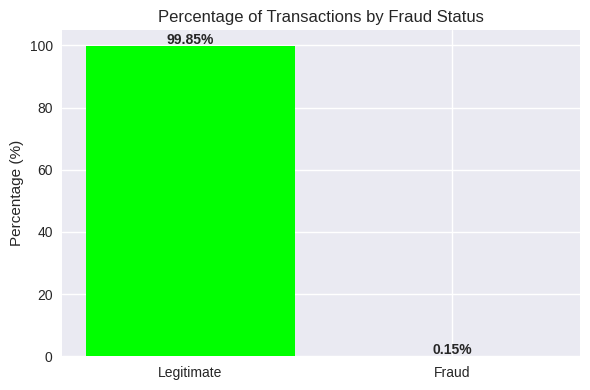

In [51]:
plt.style.use('seaborn-v0_8')

# 1. Fraud Percentage (You had this)
per = df['Fraud_Status'].value_counts(normalize=True) * 100
labels = ['Legitimate', 'Fraud']
plt.figure(figsize=(6,4))
bars = plt.bar(labels, per.values, color=['#00FF00', '#FF0000'])
plt.title('Percentage of Transactions by Fraud Status')
plt.ylabel('Percentage (%)')
for i, v in enumerate(per.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('fraud_percentage.png', dpi=150)
plt.show()


Interpretation:

* One can see major imbalance in the fraud status column.

Considerations:

* If a classification task is to be performed then it is important to ensure balanced learning for the model, considering the imbalance a hybrid strategy of undersampling of the majority class and oversampling of the minority class seems like a good option to consider.

In [52]:
# 2. Fraud by Month
monthly_fraud = df.groupby(['Month', 'Fraud_Status']).size().unstack(fill_value=0)
monthly_fraud_pct = monthly_fraud.div(monthly_fraud.sum(axis=1), axis=0) * 100

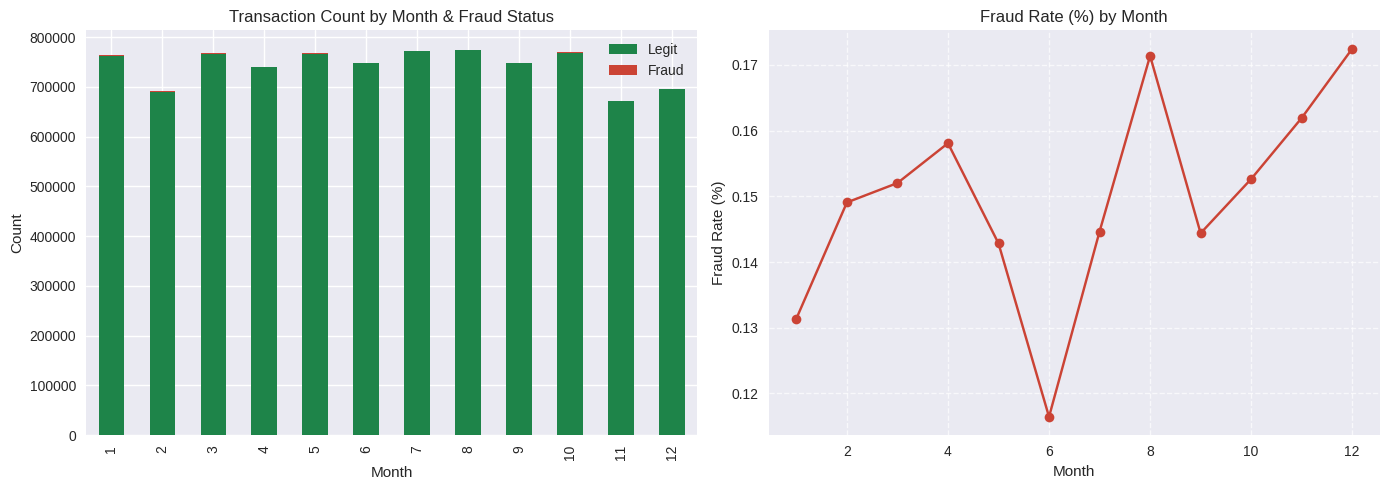

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count
monthly_fraud.plot(kind='bar', stacked=True, color=['#1e8449', '#cb4335'], ax=ax[0])
ax[0].set_title('Transaction Count by Month & Fraud Status')
ax[0].set_ylabel('Count')
ax[0].legend(['Legit', 'Fraud'])

# Percentage
monthly_fraud_pct[1].plot(kind='line', marker='o', color='#cb4335', ax=ax[1])
ax[1].set_title('Fraud Rate (%) by Month')
ax[1].set_ylabel('Fraud Rate (%)')
ax[1].set_xlabel('Month')
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('fraud_by_month.png', dpi=150)
plt.show()


In [54]:
# 3. Top 10 Risky Merchant Categories
top_fraud_categories = df[df['Fraud_Status'] == 1]['Category'].value_counts().head(10)

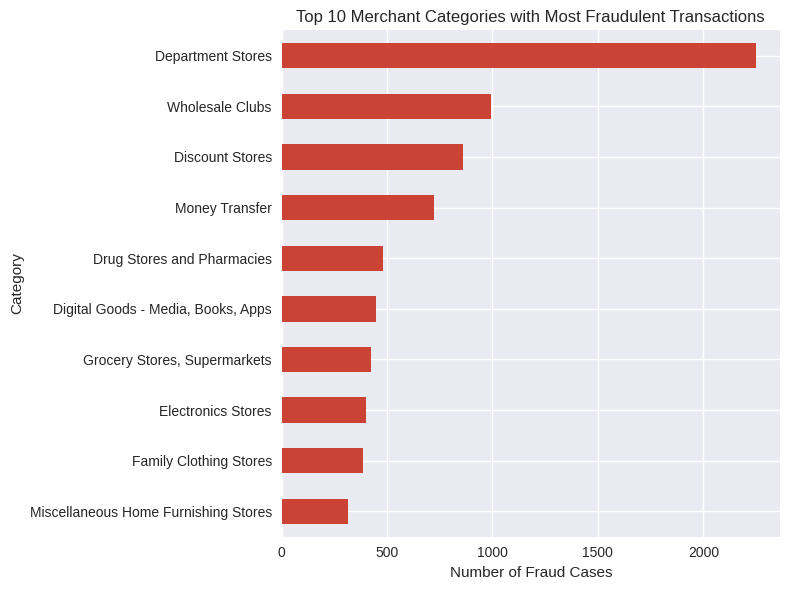

In [55]:
plt.figure(figsize=(8,6))
top_fraud_categories.sort_values().plot(kind='barh', color='#cb4335')
plt.title('Top 10 Merchant Categories with Most Fraudulent Transactions')
plt.xlabel('Number of Fraud Cases')
plt.tight_layout()
plt.savefig('top_fraud_categories.png', dpi=150)
plt.show()

In [56]:
# 4. Fraud Rate by State
state_fraud = df.groupby('MerchantState')['Fraud_Status'].agg(['count', 'sum'])
state_fraud['fraud_rate'] = (state_fraud['sum'] / state_fraud['count']) * 100
state_fraud = state_fraud.sort_values('fraud_rate', ascending=False).head(15)

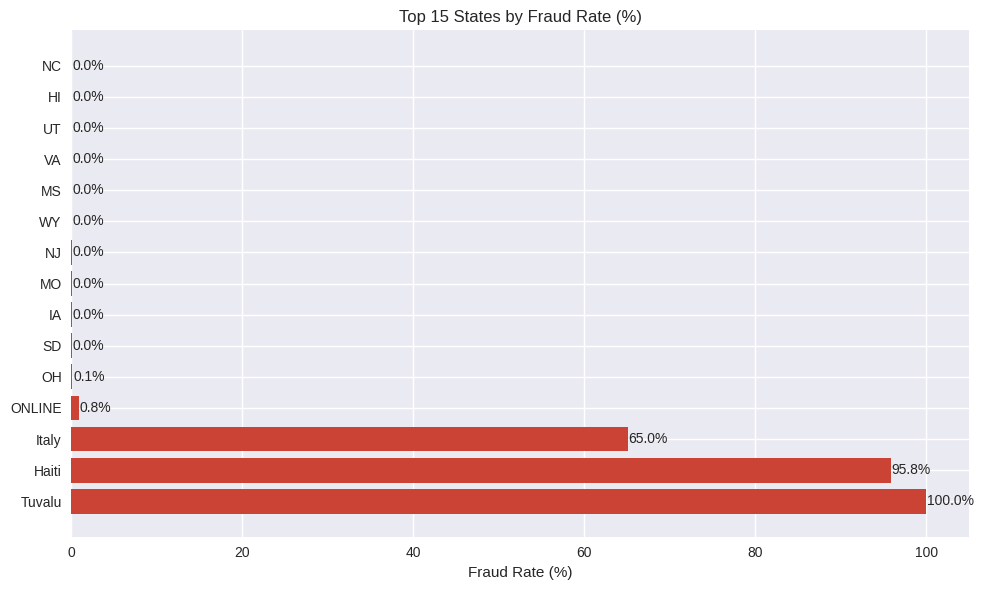

In [57]:
 # Top 15
plt.figure(figsize=(10,6))
plt.barh(state_fraud.index, state_fraud['fraud_rate'], color='#cb4335')
plt.title('Top 15 States by Fraud Rate (%)')
plt.xlabel('Fraud Rate (%)')
for i, v in enumerate(state_fraud['fraud_rate']):
    plt.text(v + 0.1, i, f"{v:.1f}%", va='center')
plt.tight_layout()
plt.savefig('fraud_by_state.png', dpi=150)
plt.show()

In [59]:
# Check for NaNs or Infs in the 'Amount' column
df['Amount'].isna().sum(), (df['Amount'] == float('inf')).sum(), (df['Amount'] == -float('inf')).sum()

(np.int64(0), np.int64(0), np.int64(0))

In [64]:
# Save summary tables for Power BI
monthly_fraud.to_csv('Monthly_Fraud_Count.csv')
state_fraud.to_csv('State_Fraud_Rate.csv')
top_fraud_categories.to_frame('Fraud_Count').to_csv('Top_Fraud_Categories.csv')

# ==============================
# 9. CREATE & EXPORT DIMENSION TABLE
# ==============================

In [65]:
# Dim_User (from users df, already cleaned)
dim_user = users.copy()
dim_user.to_csv('Dim_User.csv', index=False)
print("✅ Exported: Dim_User.csv")

✅ Exported: Dim_User.csv


In [66]:
# Dim_Card (from card df, already cleaned)
dim_card = card.copy()
dim_card.to_csv('Dim_Card.csv', index=False)
print("✅ Exported: Dim_Card.csv")

✅ Exported: Dim_Card.csv


In [67]:
# Dim_MCC
dim_mcc = df2.copy()
dim_mcc.to_csv('Dim_MCC.csv', index=False)
print("✅ Exported: Dim_MCC.csv")

✅ Exported: Dim_MCC.csv


In [68]:
# Fact_Transaction (main table)
fact_transaction = df[[
    'ID', 'Date', 'ClientID', 'Amount', 'UseChip', 'MerchantID',
    'MerchantCity', 'MerchantState', 'ZIP', 'MCC', 'Error',
    'Fraud_Status', 'Category', 'Payment_Type', 'Day', 'Month',
    'Days_Since_Account_Open', 'User_Transaction_Count',
    'Amount_ZScore', 'Is_Weekend'
]].copy()
fact_transaction.to_csv('Fact_Transaction.csv', index=False)
print("✅ Exported: Fact_Transaction.csv")

✅ Exported: Fact_Transaction.csv


# ==============================
# 10. FINAL SUMMARY & DATA QUALITY REPORT
# ==============================


In [70]:
print("\n" + "="*50)
print("📊 FINAL DATA QUALITY REPORT")
print("="*50)
print(f"Fact_Transaction Rows: {fact_transaction.shape[0]:,}")
print(f"Fact_Transaction Columns: {fact_transaction.shape[1]}")
print(f"Overall Fraud Rate: {fact_transaction['Fraud_Status'].mean()*100:.3f}%")
print(f"Total Missing Values: {fact_transaction.isnull().sum().sum()}")
print(f"Date Range: {fact_transaction['Date'].min()} to {fact_transaction['Date'].max()}")

print("\n✅ All files ready !")
print("📁 Exported Files:")
print("   - Fact_Transaction.csv")
print("   - Dim_User.csv")
print("   - Dim_Card.csv")
print("   - Dim_MCC.csv")
print("   - Monthly_Fraud_Count.csv")
print("   - State_Fraud_Rate.csv")
print("   - Top_Fraud_Categories.csv")
print("   - *.png (visualizations)")

import tarfile
from google.colab import files

# List of files to include in the compressed archive
files_to_compress = [
    'Fact_Transaction.csv',
    'Dim_User.csv',
    'Dim_Card.csv',
    'Dim_MCC.csv',
    'Monthly_Fraud_Count.csv',
    'State_Fraud_Rate.csv',
    'Top_Fraud_Categories.csv',
    'fraud_by_month.png',
    'fraud_by_state.png',
    'fraud_percentage.png',
    'credit_distribution.png',
    'top_fraud_categories.png'
]

# Create a tar.gz file
with tarfile.open('files_to_compress.tar.gz', 'w:gz') as tar:
    for file in files_to_compress:
        tar.add(file)

# Download the compressed tar.gz file
files.download('files_to_compress.tar.gz')

print("✅ Files zipped and ready for download.")



📊 FINAL DATA QUALITY REPORT
Fact_Transaction Rows: 8,914,963
Fact_Transaction Columns: 20
Overall Fraud Rate: 0.150%
Total Missing Values: 0
Date Range: 2010-01-01 00:01:00 to 2019-10-31 23:57:00

✅ All files ready !
📁 Exported Files:
   - Fact_Transaction.csv
   - Dim_User.csv
   - Dim_Card.csv
   - Dim_MCC.csv
   - Monthly_Fraud_Count.csv
   - State_Fraud_Rate.csv
   - Top_Fraud_Categories.csv
   - *.png (visualizations)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files zipped and ready for download.
